# Analysis of MD data descriptions

## Prerequise packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Description length analysis

In [2]:
# Load data
datasets = pd.read_parquet(
    "https://sandbox.zenodo.org/record/1169962/files/datasets.parquet"
)
# Create a description length column
df = datasets.copy()
df.loc[:, "description_length"] = df["description"].str.len() + df["title"].str.len()
if df["description_length"].isnull().values.any():
    df = df.dropna(subset = ["description_length", "title", "description"])
print("Number of description : ", df.shape[0])

Number of description :  1948


Our dataset is composed of 1948 description where in this analysis, the "description" corresponds to the titles and descriptions associated with the dataset

### Describe for each dataset

In [3]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
grouped = df.groupby(["dataset_origin"])["description_length"]
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
dataset_origin,,,,,,,,
figshare,913,826,799,14,110,583,1494,7100
osf,24,289,264,30,136,191,377,1171
zenodo,1011,809,797,30,383,604,980,11362


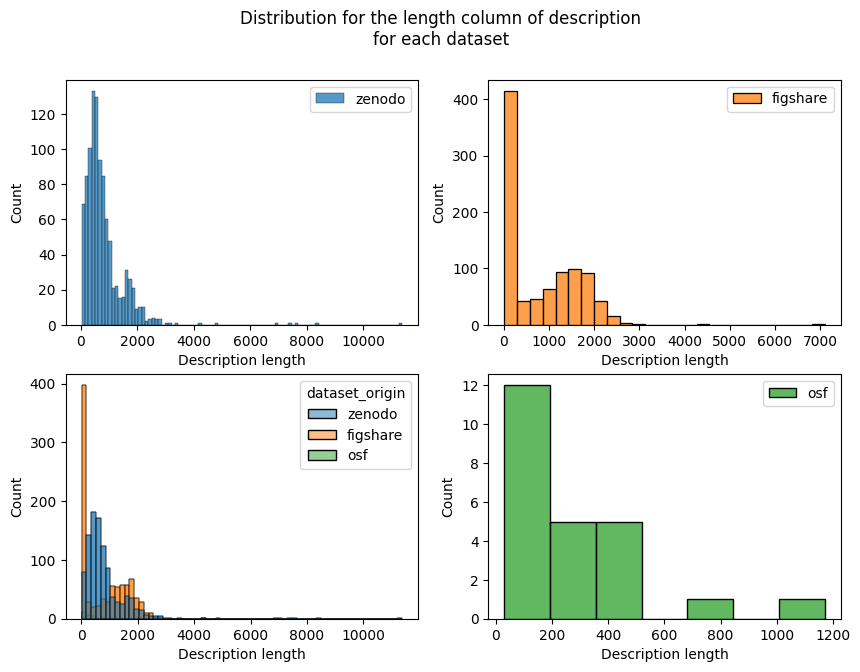

In [4]:
dataset_origin = ["zenodo", "figshare", "osf"]
fig, axs = plt.subplots(2, 2, figsize=(10, 7))
for i in range(len(axs)):
    for j in range(i, len(axs[i])):
        sns.histplot(
            data=df[df["dataset_origin"] == dataset_origin[i+j]],
            x="description_length", 
            ax=axs[i, j], 
            color= "C" + str(i + j)
        )
        axs[i, j].legend([dataset_origin[i+j]])
        axs[i, j].set_xlabel("Description length")
        if i == j:
            sns.histplot(
                data=df,
                x="description_length",
                hue="dataset_origin",
                palette=["C0", "C1", "C2"],
                ax=axs[1, 0]
            )
            axs[1, 0].set_xlabel("Description length")
fig.suptitle("Distribution for the length column of description\nfor each dataset")
plt.show()

The histograms show us the number of datasets according to the length of their description. For example, we can see a large number of datasets coming from figshare where the length of their description is short. This distribution show us that our training dataset will be composed in large part by datasets coming from zenodo and figshare since we will prefer dataset that have a long description length.

### Describe for all datasets

In [5]:
pd.DataFrame(df["description_length"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
description_length,1948,810,795,14,182,594,1244,11362


For the selection of the training datasets, we will take the descriptions where their length is higher than the median, i.e. 594.

Selected threshold :  593.5
Number of description above the threshold :  974


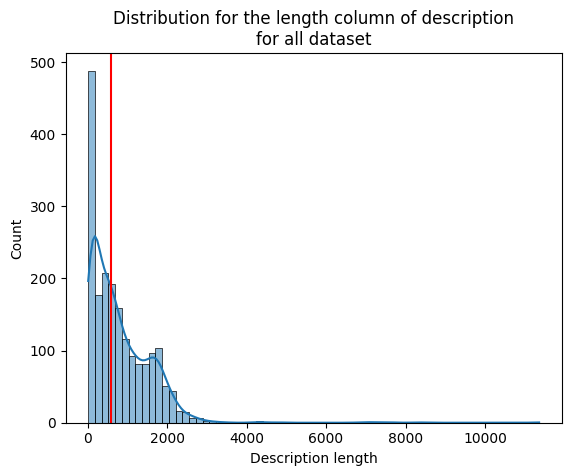

In [6]:
threshold = df["description_length"].describe()["50%"]
plt.title("Distribution for the length column of description\nfor all dataset")
sns.histplot(data=df, x="description_length", kde=True)
plt.axvline(x = threshold, color = "red", label = 'axvline - full height')
plt.xlabel("Description length")
print("Selected threshold : ", threshold)
print("Number of description above the threshold : ", len(df[df["description_length"] > threshold]))
plt.show()

The threshold is the median value as shown with the red line. It should ensure that the number of descriptions is large to make sure a large training data. Here, we have 974 descriptions with a threshold = 594.

## Lipid and protein composition from selected descriptions

The objective of this part is to analyse the homogeneity of protein and lipid data to make sure a good diversity of training data. Here, we will analyze the gro files that contain information about the composition.

In [7]:
# Load gro data
gro = pd.read_parquet(
    "https://sandbox.zenodo.org/record/1169962/files/gromacs_gro_files.parquet"
)
# Merge to obtain the description with the associated gro file.
gro_data = pd.merge(
    gro,
    datasets,
    how="left",
    on=["dataset_id", "dataset_origin"],
    validate="many_to_one",
)

# Select gro files associed to the selected descriptions
gro_data.loc[:, "description_length"] = gro_data["description"].str.len() + gro_data["title"].str.len()
if gro_data["description_length"].isnull().values.any():
    gro_data = gro_data.dropna(subset=["description_length", "title", "description"])
gro_data = gro_data[gro_data["description_length"] > threshold]
print("Number of files: ", gro_data.shape[0])

Number of files:  6477


Here, we have 6473 gro files where many of files can be associated with a description.

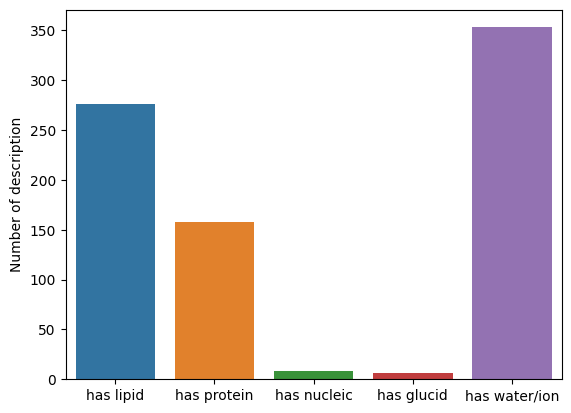

In [8]:
# Get the number of descriptions by molecules
composition_value = gro_data.groupby("dataset_id").agg(
    has_lipid=("has_lipid", "any"),
    has_protein=("has_protein", "any"),
    has_nucleic=("has_nucleic", "any"),
    has_glucid=("has_glucid", "any"),
    has_water_ion=("has_water_ion", "any"),
).sum()
# Display the barplot
composition_idx = ["has lipid", "has protein", "has nucleic", "has glucid", "has water/ion"]
sns.barplot(x=composition_idx, y=composition_value)
plt.ylabel("Number of description")
plt.show()

The histogram illustrates the number of descriptions that should be interested in compositions. For example, it suggests that there are a large number of descriptions associated with gro files that are composed of water and ion. A large number of description should give information about the composition in the description.

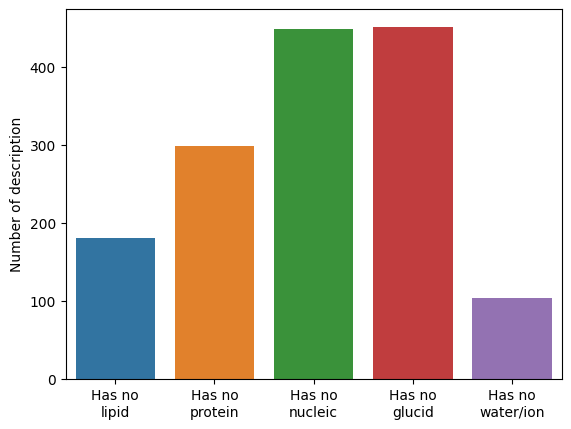

In [9]:
# Get the number of descriptions that do not have molecules
composition_value = (~gro_data.groupby("dataset_id").agg(
    has_lipid=("has_lipid", "any"),
    has_protein=("has_protein", "any"),
    has_nucleic=("has_nucleic", "any"),
    has_glucid=("has_glucid", "any"),
    has_water_ion=("has_water_ion", "any"),
)).sum()
# Display the barplot
composition_idx = ["Has no\nlipid", "Has no\nprotein", "Has no\nnucleic", "Has no\nglucid", "Has no\nwater/ion"]
composition_value
sns.barplot(x=composition_idx, y=composition_value)
plt.ylabel("Number of description")
plt.show()

## Cosinus similarity

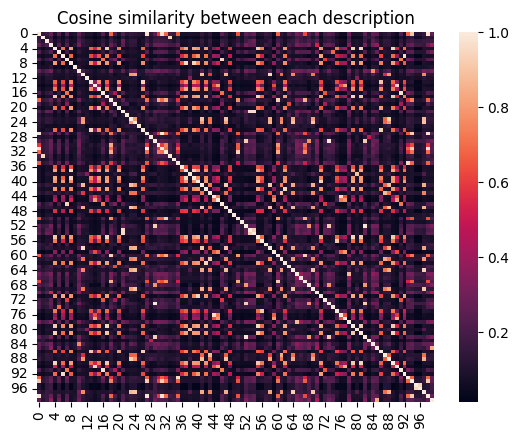

In [10]:
description_data = gro_data.copy()[["title", "description"]]
# Remove duplicate description
description_data = description_data.drop_duplicates("description")
# Create corpus column
description_data["corpus"] = description_data["title"] + " " + description_data["description"]
# Calcul the cosine similarity
vectorizer = TfidfVectorizer()
trsfm = vectorizer.fit_transform(description_data["corpus"])
data = pd.DataFrame([cosine_similarity(trsfm[i:i+1], trsfm)[0] for i in range(len(description_data["corpus"]))])
heatmap = sns.heatmap(data.iloc[0:100, 0:100]).set(title="Cosine similarity between each description")

Here is a visualization of the similiarity between each description by using cosine similarity. The cosine similarity will allow us to select descriptions that are not very similar to make sure a good diversity of data. If a score is low then it's not similar.